In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow",
        "pandas"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.1.2
tiktoken version: 0.9.0
torch version: 2.6.0+cu126
tensorflow version: 2.19.0
pandas version: 2.2.3


In [2]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "appendix-E", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

import torch
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")
print(device)

F:\project\LLMs-from-scratch-CN\appendix-E\01_main-chapter-code
cuda


# 1.2 准备数据集

In [ ]:
# from pathlib import Path
# import pandas as pd
# from previous_chapters import (
#     download_and_unzip_spam_data,
#     create_balanced_dataset,
#     random_split
# )
#
# url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# zip_path = "sms_spam_collection.zip"
# extracted_path = "sms_spam_collection"
# data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
#
# download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
#


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken
from previous_chapters import SpamDataset

torch.manual_seed(123)

num_workers = 0
batch_size = 8

# 构建dataset和dataloader
tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)

In [4]:
# 查看一个batch的数据
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [5]:
# 查看batch数
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
18 validation batches
37 test batches


## 1.3 模型的初始化

In [8]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # 词汇表大小
    "context_length": 1024,  # 上下文长度
    "drop_rate": 0.0,        # Dropout比率
    "qkv_bias": True         # 查询-键-值 偏置
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [11]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer).to(device),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [14]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [15]:
from previous_chapters import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


# 1.4 使用LoRA进行参数高效微调

In [17]:
import math

# 构建LoRA layer
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        # A矩阵进行kaiming初始化，B矩阵进行全0初始化
        # 该初始化方式，保证添加LoRA层后微调前，模型的输出不变
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [18]:
# 构建整合了LoRA Layer的线性层
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [19]:
# 将模型中的所有线性层替换为LoRA层
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # replace
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # 递归
            replace_linear_with_lora(module, rank, alpha)

In [20]:
# 冻结原模型的参数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [21]:
# 替换线性层为可训练的LoRA层
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters after: 2,666,528


In [22]:
model.to(device)

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [23]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [24]:
# 模型训练
import time
from previous_chapters import train_classifier_simple

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Total training time: {execution_time_minutes:.2f} mins")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.396, Val loss 0.364
Ep 1 (Step 000100): Train loss 0.111, Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.135, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.007, Val loss 0.055
Ep 2 (Step 000250): Train loss 0.020, Val loss 0.188
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.140, Val loss 0.062
Ep 3 (Step 000350): Train loss 0.006, Val loss 0.089
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.005, Val loss 0.033
Ep 4 (Step 000450): Train loss 0.010, Val loss 0.074
Ep 4 (Step 000500): Train loss 0.020, Val loss 0.518
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.007, Val loss 0.469
Ep 5 (Step 000600): Train loss 0.000, Val loss 0.326
Training accuracy: 97.50% | Validation accuracy: 100.00%
Total training time: 4.40 m

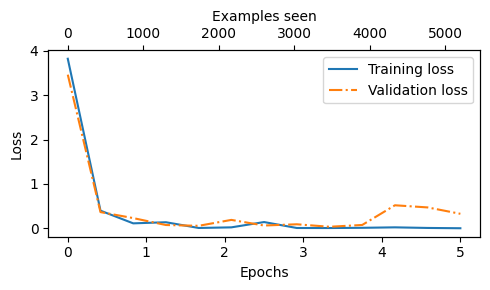

In [28]:
from previous_chapters import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [29]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.65%
Validation accuracy: 99.31%
Test accuracy: 96.28%
